In [1]:
# 📚 Basic libraries
import pandas as pd
import numpy as np 

# 🤖 Machine Learning
# models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
# feature engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder


# Project libraries
from utils.plots import *
from utils.file_handler import *
from utils import cleanup
from utils.linear_regression import linear_regression_test
from utils.common_viz import model_validation
from utils.common_viz import corr_heatmap

# ⚙️ Settings
pd.set_option('display.max_columns', None) # display all columns
import warnings
warnings.filterwarnings('ignore') # ignore warnings

# Logging
import logging
# setup logging level
logging.getLogger().setLevel(logging.DEBUG)

In [26]:
# import dataset
dataset_path = f'{DATASETS_PATH}/king_country_houses_aa.csv'
data = pd.read_csv(dataset_path)
df = data.copy()
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
target_variable = 'price'

## Feature engineering

Clustering zip-codes using K-Means

- To group nearby zip codes together → Similar economic/geographic areas may influence house prices.
- To simplify data → Instead of many zip codes, we now have just 5 clusters, making it easier for the model to learn patterns.
- To reduce complexity → Avoid the issue of sparse features from one-hot encoding.

In [4]:
df = df.copy()

# Extract unique zip codes
zip_df = df[['zipcode']].drop_duplicates().reset_index(drop=True)

# Apply K-Means clustering
num_clusters = 5  # You can change this number based on experimentation
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
zip_df['zipcode_cluster'] = kmeans.fit_predict(zip_df[['zipcode']])

# Merge the cluster labels back to the original dataframe
df = df.merge(zip_df, on='zipcode', how='left')

# Display the first few rows
print(df[['zipcode', 'zipcode_cluster']].drop_duplicates().sort_values(by='zipcode'))

     zipcode  zipcode_cluster
38     98001                2
18     98002                2
6      98003                2
66     98004                2
70     98005                2
..       ...              ...
120    98177                1
0      98178                1
299    98188                1
7      98198                1
91     98199                1

[70 rows x 2 columns]


Encode zipcodes to make categorical data useful for training a model.

In [5]:
# Initialize LabelEncoder
label_enc = LabelEncoder()

# Apply Label Encoding to 'zipcode' column
df['zipcode_encoded'] = label_enc.fit_transform(df['zipcode'])

# Drop the original 'zipcode' column (optional, if not needed)
df = df.drop(columns=['zipcode'])

Interpreting date information:
- Convert date column to datetime format and extract year as 'yr_sold'
- Count age of the building and save as new column
- Count years since last removation and save as new column

In [6]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S')

# Create a new column 'yr_sold' by extracting the year from 'date'
df['yr_sold'] = df['date'].dt.year

# Create a new column 'building_age' calculating the age of the building
df['building_age'] = df['yr_sold'] - df['yr_built']

# Create a new column 'yrs_after_renovation' calculating years since last renovation
df['yrs_since_renovation'] = df['yr_sold'] - df['yr_renovated']
df['yrs_since_renovation'] = df['yrs_since_renovation'].where(df['yr_renovated'] > 0, 0)


Interpreting space information:
- Total bathrooms per bedroom ratio: bath_bed_ratio = bathrooms / bedrooms (handle division by zero)
- Total space per room: sqft_per_room = sqft_living / (bedrooms + bathrooms)


In [7]:
# Create 'bath_bed_ratio' while handling division by zero
df['bath_bed_ratio'] = df['bathrooms'] / df['bedrooms']
df['bath_bed_ratio'] = df['bath_bed_ratio'].replace([float('inf'), -float('inf')], 0)  # Handle division by zero

# Create 'sqft_per_room' while handling division by zero
df['sqft_per_room'] = df['sqft_living'] / (df['bedrooms'] + df['bathrooms'])
df['sqft_per_room'] = df['sqft_per_room'].replace([float('inf'), -float('inf')], 0)  # Handle division by zero

Log transformation for highly skewed variables:
- sqft_lot
- sqft_lot15
- sqft_above
- sqft_basement
- sqft_living


In [8]:
# Apply Log Transformation to highly skewed variables
for col in ['sqft_lot', 'sqft_lot15', 'sqft_above', 'sqft_basement', 'sqft_living']:
    df[f'log_{col}'] = np.log1p(df[col])  # log1p(x) = log(x + 1) to handle zero values

Extracting data from ID column and dropping it:
- Which houses were sold more than once?
- How many times the house was sold?
- Years since last sale?

In [9]:
# Create a column that counts how many times each house (ID) appears in the dataset.
df['sale_count'] = df.groupby('id')['id'].transform('count')

# Mark houses sold multiple times (1 if sold multiple times, 0 if sold only once)
df['multiple_sales'] = df['sale_count'].apply(lambda x: 1 if x > 1 else 0)

# Sort the dataframe by 'id' and 'yr_sold' to ensure correct order
df = df.sort_values(by=['id', 'yr_sold'])

# Calculate the difference in years between consecutive sales for the same house
df['yrs_since_previous_sale'] = df.groupby('id')['yr_sold'].diff().fillna(0)

# Now the ID column becomes redundant for ML purposes
df = df.drop(columns=['id'])

### Cleanup

In [10]:
# create instance of Auto EDA class
eda_utils = cleanup.Auto_EDA(df)

In [11]:
logging.info(f"Number of rows before cleanup: {eda_utils.init_rows}")
eda_utils.auto_cleanup()
logging.info(f"Number of rows after cleanup: {eda_utils.count_rows()}")

INFO:root:Number of rows before cleanup: 21613
INFO:root:Dataset has no empty spaces.
INFO:root:Dataset has no duplicates.
INFO:root:Number of rows after cleanup: 21613


In [12]:
df_nulls = eda_utils.count_nulls()
print(df_nulls)

                         is_na  not_na  na_percent na_percent_pretty
bath_bed_ratio               7   21606    0.032388             0.03%
date                         0   21613    0.000000             0.00%
price                        0   21613    0.000000             0.00%
bedrooms                     0   21613    0.000000             0.00%
bathrooms                    0   21613    0.000000             0.00%
sqft_living                  0   21613    0.000000             0.00%
sqft_lot                     0   21613    0.000000             0.00%
floors                       0   21613    0.000000             0.00%
waterfront                   0   21613    0.000000             0.00%
view                         0   21613    0.000000             0.00%
condition                    0   21613    0.000000             0.00%
grade                        0   21613    0.000000             0.00%
sqft_above                   0   21613    0.000000             0.00%
sqft_basement                0   2

In [13]:
df['bath_bed_ratio'] = df['bath_bed_ratio'].fillna(0)

In [14]:
eda_utils = cleanup.Auto_EDA(df)
df_nulls = eda_utils.count_nulls()
print(df_nulls)

                         is_na  not_na  na_percent na_percent_pretty
date                         0   21613         0.0             0.00%
price                        0   21613         0.0             0.00%
bedrooms                     0   21613         0.0             0.00%
bathrooms                    0   21613         0.0             0.00%
sqft_living                  0   21613         0.0             0.00%
sqft_lot                     0   21613         0.0             0.00%
floors                       0   21613         0.0             0.00%
waterfront                   0   21613         0.0             0.00%
view                         0   21613         0.0             0.00%
condition                    0   21613         0.0             0.00%
grade                        0   21613         0.0             0.00%
sqft_above                   0   21613         0.0             0.00%
sqft_basement                0   21613         0.0             0.00%
yr_built                     0   2

### Collecting the features

In [15]:
# feature groups
continuous_features = []
descrete_features = []
ordinal_encoded_categorical_features = []

In [16]:
# all non-numeric
df.select_dtypes(exclude="number").columns.tolist()

['date']

In [17]:
df['date'].dtypes

dtype('<M8[ns]')

In [18]:
# all numeric features
numeric_columns_list = df.select_dtypes(include="number").columns.tolist()
numeric_columns_list.sort()
numeric_columns_list

['bath_bed_ratio',
 'bathrooms',
 'bedrooms',
 'building_age',
 'condition',
 'floors',
 'grade',
 'lat',
 'log_sqft_above',
 'log_sqft_basement',
 'log_sqft_living',
 'log_sqft_lot',
 'log_sqft_lot15',
 'long',
 'multiple_sales',
 'price',
 'sale_count',
 'sqft_above',
 'sqft_basement',
 'sqft_living',
 'sqft_living15',
 'sqft_lot',
 'sqft_lot15',
 'sqft_per_room',
 'view',
 'waterfront',
 'yr_built',
 'yr_renovated',
 'yr_sold',
 'yrs_since_previous_sale',
 'yrs_since_renovation',
 'zipcode_cluster',
 'zipcode_encoded']

In [19]:
continuous_features.append('bath_bed_ratio')
descrete_features.append('bathrooms')
descrete_features.append('bedrooms')
descrete_features.append('building_age')
ordinal_encoded_categorical_features.append('condition')
descrete_features.append('floors')
ordinal_encoded_categorical_features.append('grade')
continuous_features.append('lat')
continuous_features.append('log_sqft_above')
continuous_features.append('log_sqft_basement')
continuous_features.append('log_sqft_living')
continuous_features.append('log_sqft_lot')
continuous_features.append('log_sqft_lot15')
continuous_features.append('long')
descrete_features.append('multiple_sales')
descrete_features.append('sale_count')
continuous_features.append('sqft_above')
continuous_features.append('sqft_basement')
continuous_features.append('sqft_living')
continuous_features.append('sqft_living15')
continuous_features.append('sqft_lot')
continuous_features.append('sqft_lot15')
continuous_features.append('sqft_per_room')
descrete_features.append('view')
ordinal_encoded_categorical_features.append('waterfront')
descrete_features.append('yr_built')
descrete_features.append('yr_renovated')
descrete_features.append('yr_sold')
descrete_features.append('yrs_since_previous_sale')
descrete_features.append('yrs_since_renovation')
descrete_features.append('zipcode_cluster')
descrete_features.append('zipcode_encoded')

print(f"continuous_features: \n {continuous_features}\n")
print(f"descrete_features: \n {descrete_features}\n")
print(f"ordinal_encoded_categorical_features: \n {ordinal_encoded_categorical_features}\n")

continuous_features: 
 ['bath_bed_ratio', 'lat', 'log_sqft_above', 'log_sqft_basement', 'log_sqft_living', 'log_sqft_lot', 'log_sqft_lot15', 'long', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_per_room']

descrete_features: 
 ['bathrooms', 'bedrooms', 'building_age', 'floors', 'multiple_sales', 'sale_count', 'view', 'yr_built', 'yr_renovated', 'yr_sold', 'yrs_since_previous_sale', 'yrs_since_renovation', 'zipcode_cluster', 'zipcode_encoded']

ordinal_encoded_categorical_features: 
 ['condition', 'grade', 'waterfront']



In [20]:
all_numeric_features = continuous_features + descrete_features
print(all_numeric_features)

['bath_bed_ratio', 'lat', 'log_sqft_above', 'log_sqft_basement', 'log_sqft_living', 'log_sqft_lot', 'log_sqft_lot15', 'long', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_per_room', 'bathrooms', 'bedrooms', 'building_age', 'floors', 'multiple_sales', 'sale_count', 'view', 'yr_built', 'yr_renovated', 'yr_sold', 'yrs_since_previous_sale', 'yrs_since_renovation', 'zipcode_cluster', 'zipcode_encoded']


## Visualization of features

In [21]:
# initiate a new instance of plots class 
# set color palette and theme for maximum of colors set to columns count
plots = Gryffindor_plots(n_columns=len(all_numeric_features), target_column=target_variable)

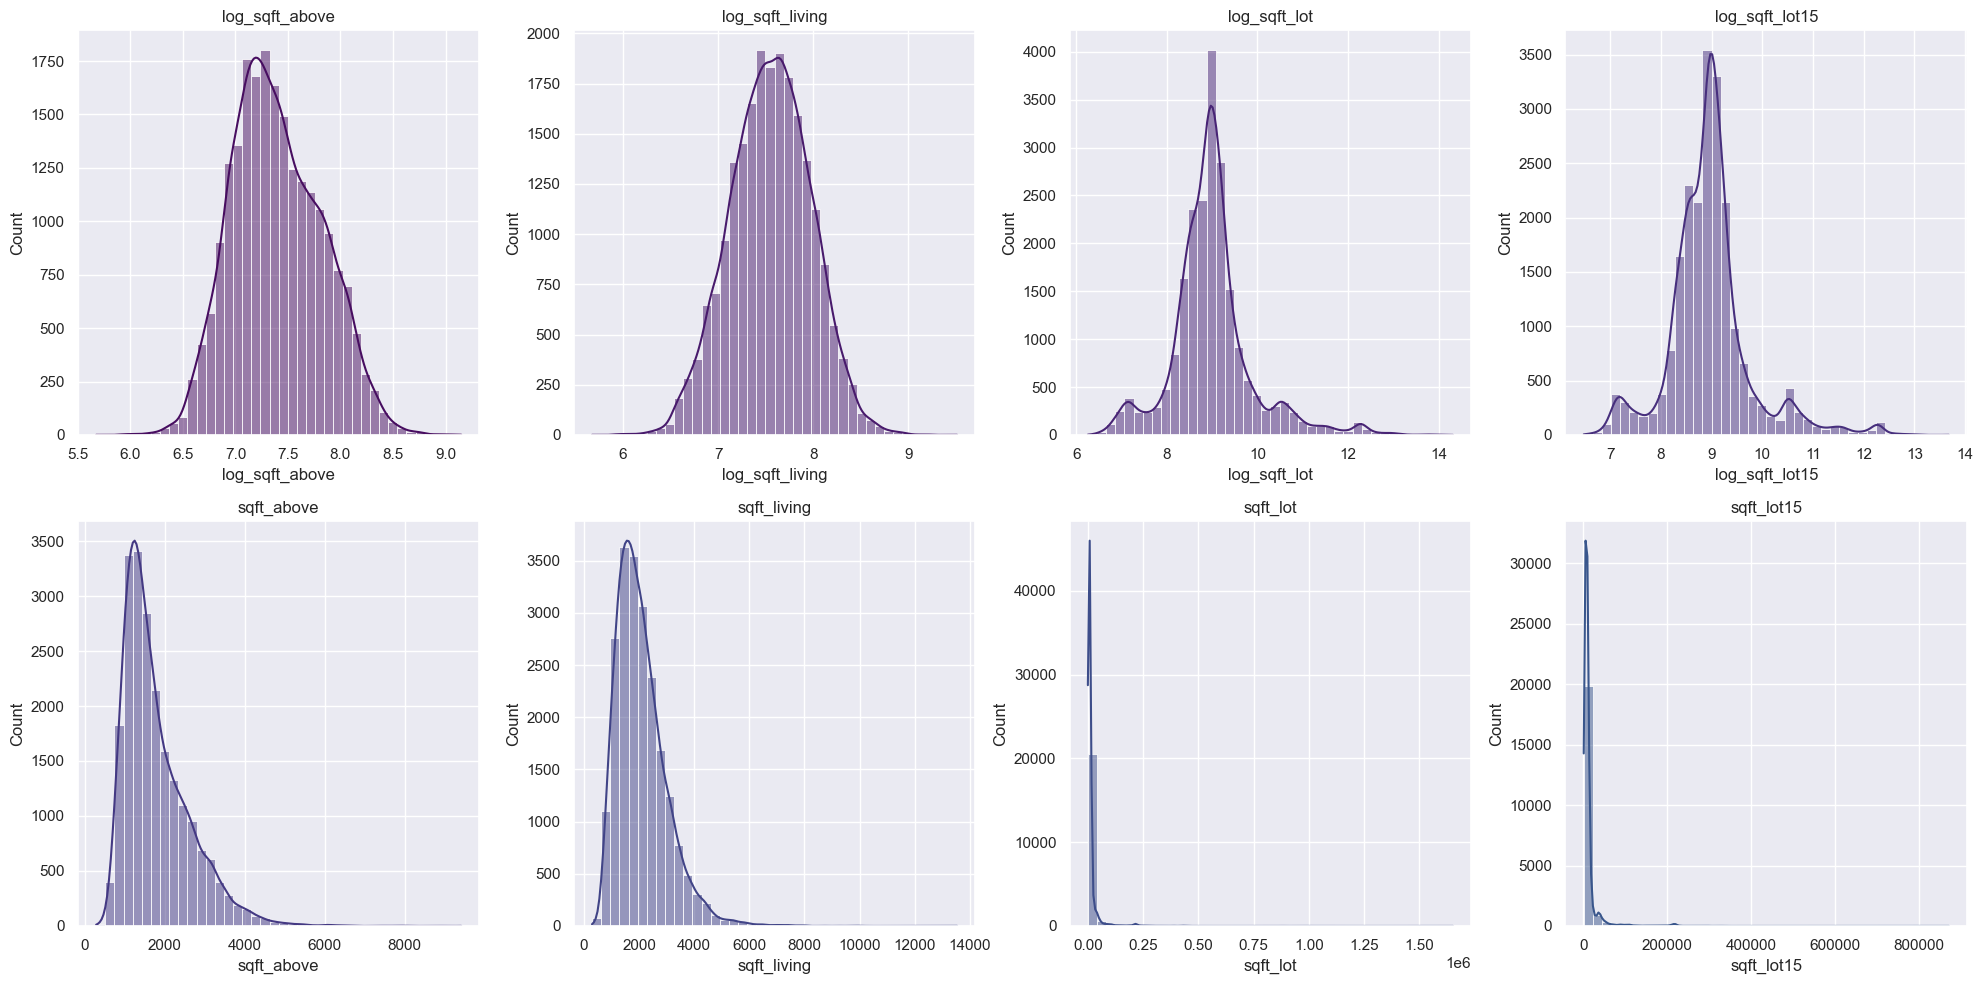

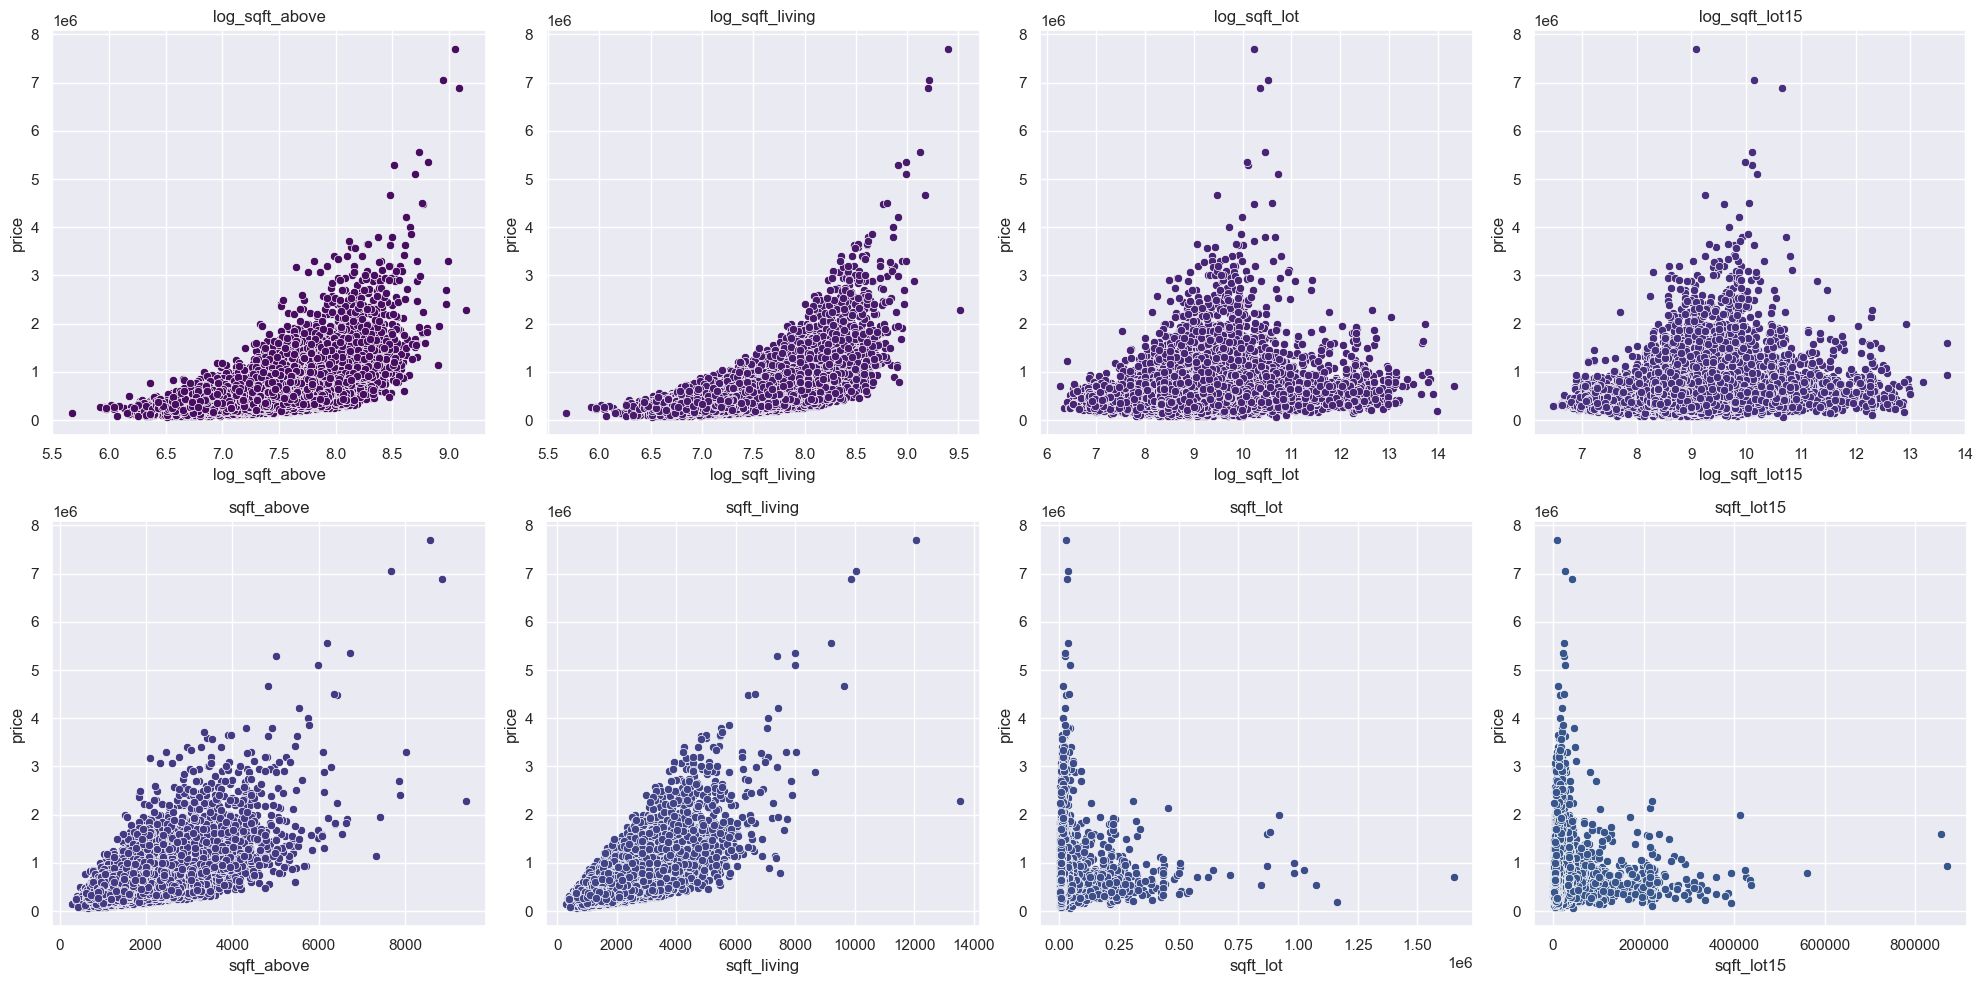

In [22]:
# to_vis = ['bath_bed_ratio', 'lat', 'log_sqft_above', 'log_sqft_basement', 'log_sqft_living', 'log_sqft_lot', 'log_sqft_lot15', 'long', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_per_room']
# to_vis = ['bathrooms', 'bedrooms', 'building_age', 'floors', 'multiple_sales', 'sale_count', 'view', 'yr_built', 'yr_renovated', 'yr_sold', 'yrs_since_previous_sale', 'yrs_since_renovation', 'zipcode_cluster', 'zipcode_encoded']

# to_vis = ['bathrooms', 'bedrooms', 'bath_bed_ratio', 'floors']
# to_vis = ['lat', 'long', 'zipcode_encoded', 'zipcode_cluster' ]
# to_vis = ['condition', 'grade', 'waterfront'] - to BARPLOT!!!
# to_vis = ['yr_sold', 'yr_built', 'building_age', 'yr_renovated', 'yrs_since_renovation', 'multiple_sales', 'sale_count', 'yrs_since_previous_sale']
to_vis = ['log_sqft_above', 'log_sqft_living', 'log_sqft_lot', 'log_sqft_lot15', 'sqft_above', 'sqft_living', 'sqft_lot', 'sqft_lot15']

plots.plots_for_columns(df, to_vis, PlotType.HISTOGRAM)
plots.plots_for_columns(df, to_vis, PlotType.SCATTER)

## Linear Regression Hyperparameters tuning

In [23]:
logging.getLogger().setLevel(logging.INFO)

# Define different subsets of features
feature_subsets = {
    "continuous": continuous_features,
    "discrete": descrete_features,
    "categorical": ordinal_encoded_categorical_features,
    "all_numeric": all_numeric_features
}

# Define test sizes to experiment with
test_sizes = [0.2, 0.3, 0.4]

# Define different random_state values for variability
random_states = [15, 42, 100]

# Create dictionary to store test results
dict_model_test = {}

# Loop through different feature subsets, test sizes, and random states
for subset_name, feature_list in feature_subsets.items():
    for test_size in test_sizes:
        for random_state in random_states:
            # X/y split
            X = df[feature_list]
            y = df["price"]

            # Run linear regression test
            key = f"LR_{subset_name}_ts{test_size}_rs{random_state}"
            dict_model_test[key] = linear_regression_test(X, y, test_size, random_state)

df_model_test = pd.DataFrame(dict_model_test).T

# Apply formatting to ensure all values are displayed with 4 decimal places
columns_to_format = ['R2', 'MAE', 'RMSE', 'MSE']
df_model_test[columns_to_format] = df_model_test[columns_to_format].map(lambda x: f"{x:.4f}")

df_model_test.sort_values('R2', ascending=False, inplace=True)

df_model_test

,test_size,random_state,R2,MAE,RMSE,MSE
LR_all_numeric_ts0.2_rs15,0.2,15.0,0.7128,124402.4665,203006.7754,41211750865.0296
LR_all_numeric_ts0.3_rs15,0.3,15.0,0.7027,127105.1038,207959.6066,43247197966.1649
LR_all_numeric_ts0.4_rs15,0.4,15.0,0.6937,128083.5874,208299.5182,43388689297.3495
LR_all_numeric_ts0.4_rs100,0.4,100.0,0.6922,129307.3639,215034.9612,46240034517.3156
LR_all_numeric_ts0.3_rs100,0.3,100.0,0.6848,130815.2597,214304.7771,45926537508.0975
LR_all_numeric_ts0.4_rs42,0.4,42.0,0.6846,127676.4889,198895.7666,39559525982.6036
LR_all_numeric_ts0.3_rs42,0.3,42.0,0.6796,128027.7197,198387.5351,39357614087.2996
LR_all_numeric_ts0.2_rs100,0.2,100.0,0.6761,129810.0785,209166.0131,43750421022.2316
LR_all_numeric_ts0.2_rs42,0.2,42.0,0.6627,128602.0373,200743.4795,40297944556.7745
LR_continuous_ts0.2_rs15,0.2,15.0,0.6572,137242.1804,221760.4922,49177715896.3756


## Linear Regression 
- All numeric features
- test size 20%
- random state 15

In [24]:
# Test/Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

logging.debug(f'70% for training data: {len(X_train)}.')
logging.debug(f'30% for test data: {len(X_test)}.')

# Train the model
final_linear_regression_model = LinearRegression()
final_linear_regression_model.fit(X_train,y_train)

# Make predictions on the test dataset
predictions = final_linear_regression_model.predict(X_test)
r2_3 = r2_score(y_test, predictions)
MAE_3 = mean_absolute_error(y_test, predictions)
RMSE_3 = root_mean_squared_error(y_test, predictions)
MSE_3 = mean_squared_error(y_test, predictions)

#Printing the results
print(f"R2 = {round(r2_3, 4)}")
print(f"MAE = {round(MAE_3, 4)}")
print(f"RMSE = {round(RMSE_3, 4)}")
print(f"MSE =  {round(MSE_3, 4)}")

R2 = 0.7128
MAE = 124402.4665
RMSE = 203006.7754
MSE =  41211750865.0296


In [25]:
# Save model to a file
save_model_pickle(model=final_linear_regression_model, filename='final_linear_regression_model')


INFO:root:Model file pickle is updated: /Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/mini_projects/mini-project-ironkaggle/models/final_linear_regression_model.json
